In [ ]:
# !pip install imbalanced-learn

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load cleaned classification dataset

In [ ]:
df = pd.read_csv("classification_data.csv")

In [ ]:
# Define X and y
X = df.drop('Mortality_Status', axis=1)
y = df['Mortality_Status']

In [ ]:
X.columns.tolist()


['Age',
 'Sex',
 'Occupation',
 'T_Stage',
 'N_Stage',
 '6th_Stage',
 'Differentiated',
 'Grade',
 'A_Stage',
 'Tumor_Size',
 'Estrogen_Status',
 'Progesterone_Status',
 'Regional_Node_Examined',
 'Reginol_Node_Positive']

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Check class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE :", pd.Series(y_train_smote).value_counts().to_dict())

Before SMOTE: {0: 2726, 1: 493}
After SMOTE : {0: 2726, 1: 2726}


In [ ]:
# Models
models = {
    'NB': GaussianNB(),
    'LR': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier()
}


NB Accuracy: 0.7677

NB Confusion Matrix:
 [[569 113]
 [ 74  49]]
NB Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.83      0.86       682
           1       0.30      0.40      0.34       123

    accuracy                           0.77       805
   macro avg       0.59      0.62      0.60       805
weighted avg       0.80      0.77      0.78       805


LR Accuracy: 0.8534

LR Confusion Matrix:
 [[671  11]
 [107  16]]
LR Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92       682
           1       0.59      0.13      0.21       123

    accuracy                           0.85       805
   macro avg       0.73      0.56      0.57       805
weighted avg       0.82      0.85      0.81       805


KNN Accuracy: 0.8236

KNN Confusion Matrix:
 [[643  39]
 [103  20]]
KNN Classification Report:
               precision    recall  f1-score   support

      

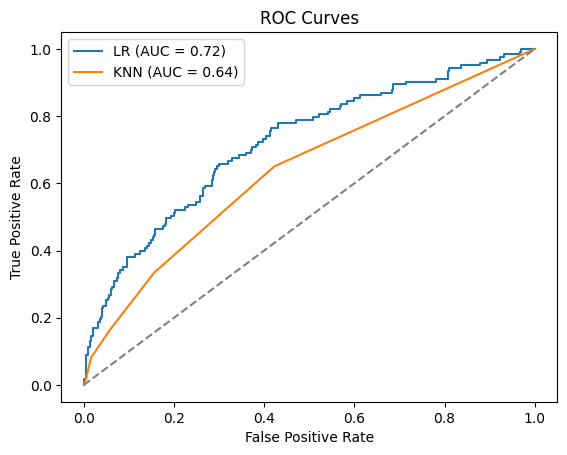

In [ ]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {accuracy:.4f}")
    print(f"\n{name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))
    if name != 'NB':
        y_probs = model.predict_proba(X_test_scaled)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        auc = roc_auc_score(y_test, y_probs)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], '--', color='grey')
plt.legend()
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
# Logistic Regression instance without hyperparameter tuning
blr = LogisticRegression(max_iter=1000)

# Train the model on the original training data
blr.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_before = blr.predict(X_test_scaled)

# Evaluate the model performance
print("Before Parameter Tuning - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_before))

print("\nBefore Parameter Tuning - Classification Report:")
print(classification_report(y_test, y_pred_before))

print(f"Before Parameter Tuning - AUC-ROC Score: {roc_auc_score(y_test, blr.predict_proba(X_test_scaled)[:, 1]):.2f}")


Before Parameter Tuning - Confusion Matrix:
[[488 194]
 [ 45  78]]

Before Parameter Tuning - Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.72      0.80       682
           1       0.29      0.63      0.39       123

    accuracy                           0.70       805
   macro avg       0.60      0.67      0.60       805
weighted avg       0.82      0.70      0.74       805

Before Parameter Tuning - AUC-ROC Score: 0.73


In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],            # Regularization strength
    'penalty': ['l1', 'l2'],            # L1 = Lasso, L2 = Ridge
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}

# Logistic Regression instance
lr = LogisticRegression(max_iter=1000)

# Grid search on SMOTE-resampled training data
grid = GridSearchCV(lr, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train_smote, y_train_smote)

# Best hyperparameters
print("Best Hyperparameters:", grid.best_params_)

Best Hyperparameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
# Evaluate on original test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)

In [ ]:
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, best_model.predict_proba(X_test_scaled)[:, 1]):.2f}")


Confusion Matrix:
 [[489 193]
 [ 45  78]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.72      0.80       682
           1       0.29      0.63      0.40       123

    accuracy                           0.70       805
   macro avg       0.60      0.68      0.60       805
weighted avg       0.82      0.70      0.74       805

AUC-ROC Score: 0.73
